# Processing Sequences Using RNNs and CNNs

# Setup

In [53]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.layers import LayerNormalization

In [7]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use("ggplot")
warnings.filterwarnings(action="ignore")
os.chdir('output')

# Basic RNNs

### Generate the Dataset

In [8]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [9]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [10]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

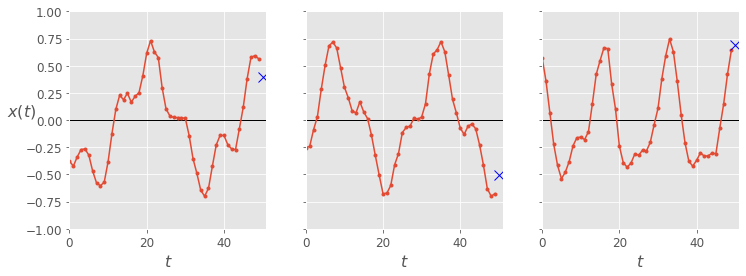

In [12]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [13]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

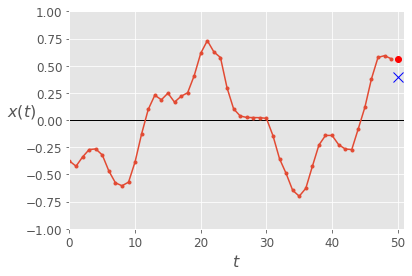

In [14]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 0s 974us/step - loss: 0.2034 - val_loss: 0.0928
Epoch 2/5
219/219 [==============================] - 0s 793us/step - loss: 0.0579 - val_loss: 0.0383
Epoch 3/5
219/219 [==============================] - 0s 808us/step - loss: 0.0275 - val_loss: 0.0202
Epoch 4/5
219/219 [==============================] - 0s 790us/step - loss: 0.0160 - val_loss: 0.0127
Epoch 5/5
219/219 [==============================] - 0s 804us/step - loss: 0.0110 - val_loss: 0.0095


In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 596us/step - loss: 0.0095


0.009548173286020756

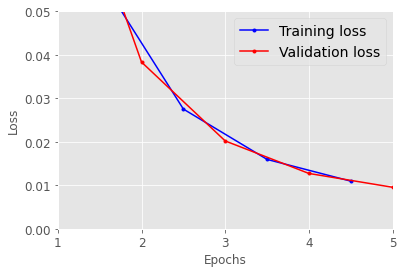

In [19]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 5, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

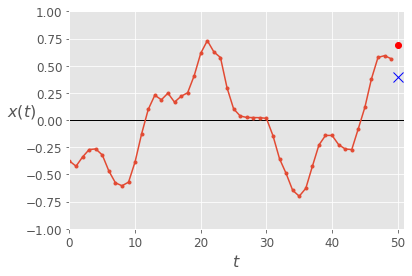

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [21]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 2s 7ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/5
219/219 [==============================] - 1s 7ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0166 - val_loss: 0.0151


In [22]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0151


0.015121601521968842

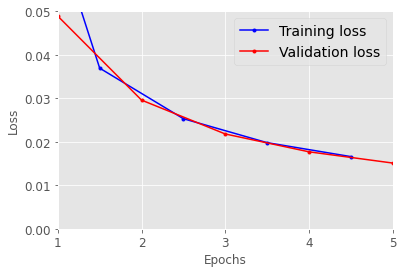

In [23]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

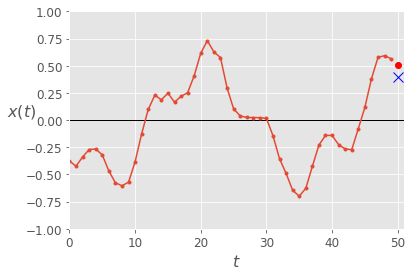

In [24]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [25]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 5s 21ms/step - loss: 0.0322 - val_loss: 0.0124
Epoch 2/5
219/219 [==============================] - 4s 20ms/step - loss: 0.0083 - val_loss: 0.0058
Epoch 3/5
219/219 [==============================] - 4s 20ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 4/5
219/219 [==============================] - 4s 20ms/step - loss: 0.0045 - val_loss: 0.0068
Epoch 5/5
219/219 [==============================] - 4s 20ms/step - loss: 0.0043 - val_loss: 0.0037


In [26]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0037


0.003706865943968296

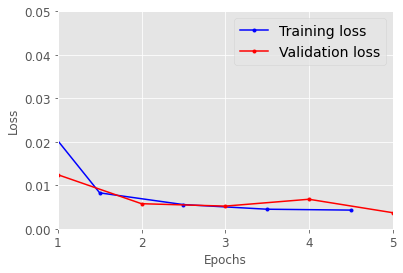

In [27]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

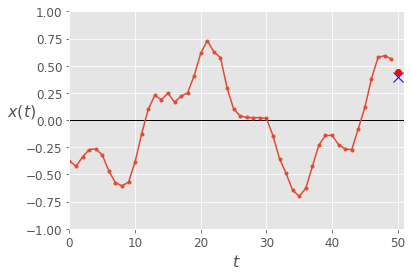

In [28]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [30]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 3s 16ms/step - loss: 0.0157 - val_loss: 0.0044
Epoch 2/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 3/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 5/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0032 - val_loss: 0.0032


In [31]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0032


0.0032091219909489155

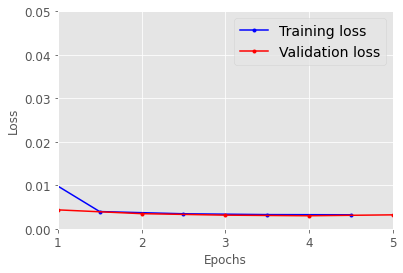

In [32]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

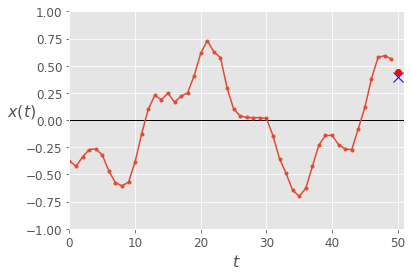

In [33]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [34]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [35]:
Y_pred.shape

(1, 10, 1)

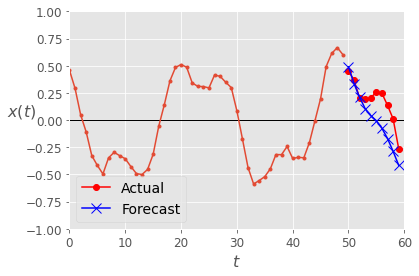

In [37]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [38]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [39]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [40]:
Y_pred.shape

(2000, 10)

In [41]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.037756447

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [42]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22187383

In [43]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 0s 1ms/step - loss: 0.1099 - val_loss: 0.0611
Epoch 2/5
219/219 [==============================] - 0s 864us/step - loss: 0.0501 - val_loss: 0.0422
Epoch 3/5
219/219 [==============================] - 0s 860us/step - loss: 0.0384 - val_loss: 0.0353
Epoch 4/5
219/219 [==============================] - 0s 855us/step - loss: 0.0330 - val_loss: 0.0310
Epoch 5/5
219/219 [==============================] - 0s 882us/step - loss: 0.0296 - val_loss: 0.0284


Now let's create an RNN that predicts all 10 next values at once:

In [44]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 4s 16ms/step - loss: 0.0748 - val_loss: 0.0374
Epoch 2/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0310 - val_loss: 0.0240
Epoch 3/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0199 - val_loss: 0.0171
Epoch 4/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0160 - val_loss: 0.0152
Epoch 5/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0141 - val_loss: 0.0140


In [45]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

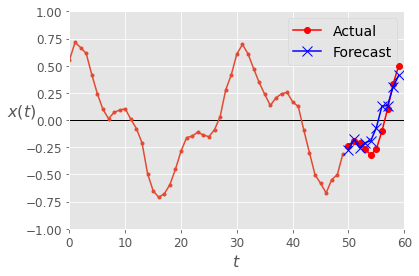

In [46]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [47]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [48]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [49]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 4s 16ms/step - loss: 0.0485 - last_time_step_mse: 0.0364 - val_loss: 0.0394 - val_last_time_step_mse: 0.0240
Epoch 2/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0407 - last_time_step_mse: 0.0297 - val_loss: 0.0379 - val_last_time_step_mse: 0.0260
Epoch 3/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0342 - last_time_step_mse: 0.0227 - val_loss: 0.0320 - val_last_time_step_mse: 0.0208
Epoch 4/5
219/219 [==============================] - 3s 14ms/step - loss: 0.0306 - last_time_step_mse: 0.0189 - val_loss: 0.0314 - val_last_time_step_mse: 0.0190
Epoch 5/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0290 - last_time_step_mse: 0.0170 - val_loss: 0.0274 - val_last_time_step_mse: 0.0160


In [50]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

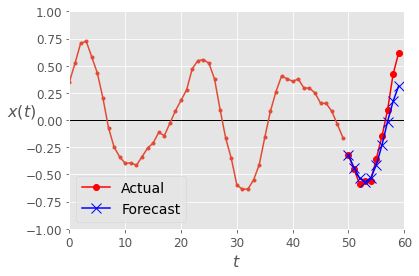

In [51]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [52]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 4s 17ms/step - loss: 0.1751 - last_time_step_mse: 0.1621 - val_loss: 0.0876 - val_last_time_step_mse: 0.0803
Epoch 2/5
219/219 [==============================] - 3s 16ms/step - loss: 0.0553 - last_time_step_mse: 0.0452 - val_loss: 0.0529 - val_last_time_step_mse: 0.0430
Epoch 3/5
219/219 [==============================] - 4s 16ms/step - loss: 0.0468 - last_time_step_mse: 0.0376 - val_loss: 0.0453 - val_last_time_step_mse: 0.0354
Epoch 4/5
219/219 [==============================] - 3s 16ms/step - loss: 0.0432 - last_time_step_mse: 0.0343 - val_loss: 0.0423 - val_last_time_step_mse: 0.0328
Epoch 5/5
219/219 [==============================] - 3s 16ms/step - loss: 0.0403 - last_time_step_mse: 0.0308 - val_loss: 0.0396 - val_last_time_step_mse: 0.0285


# Deep RNNs with Layer Norm

In [54]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [55]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 8s 37ms/step - loss: 0.1203 - last_time_step_mse: 0.1093 - val_loss: 0.0618 - val_last_time_step_mse: 0.0498
Epoch 2/5
219/219 [==============================] - 8s 35ms/step - loss: 0.0587 - last_time_step_mse: 0.0483 - val_loss: 0.0560 - val_last_time_step_mse: 0.0450
Epoch 3/5
219/219 [==============================] - 8s 34ms/step - loss: 0.0532 - last_time_step_mse: 0.0423 - val_loss: 0.0501 - val_last_time_step_mse: 0.0381
Epoch 4/5
219/219 [==============================] - 8s 35ms/step - loss: 0.0479 - last_time_step_mse: 0.0360 - val_loss: 0.0451 - val_last_time_step_mse: 0.0319
Epoch 5/5
219/219 [==============================] - 8s 35ms/step - loss: 0.0430 - last_time_step_mse: 0.0302 - val_loss: 0.0406 - val_last_time_step_mse: 0.0268


# Creating a Custom RNN Class

In [56]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [57]:
model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 7s 33ms/step - loss: 0.1638 - last_time_step_mse: 0.1532 - val_loss: 0.0699 - val_last_time_step_mse: 0.0598
Epoch 2/5
219/219 [==============================] - 7s 32ms/step - loss: 0.0623 - last_time_step_mse: 0.0509 - val_loss: 0.0563 - val_last_time_step_mse: 0.0441
Epoch 3/5
219/219 [==============================] - 7s 32ms/step - loss: 0.0532 - last_time_step_mse: 0.0403 - val_loss: 0.0500 - val_last_time_step_mse: 0.0359
Epoch 4/5
219/219 [==============================] - 7s 32ms/step - loss: 0.0477 - last_time_step_mse: 0.0332 - val_loss: 0.0446 - val_last_time_step_mse: 0.0286
Epoch 5/5
219/219 [==============================] - 7s 34ms/step - loss: 0.0427 - last_time_step_mse: 0.0271 - val_loss: 0.0402 - val_last_time_step_mse: 0.0238


# LSTMs

In [58]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 10s 44ms/step - loss: 0.0769 - last_time_step_mse: 0.0634 - val_loss: 0.0529 - val_last_time_step_mse: 0.0341
Epoch 2/5
219/219 [==============================] - 8s 36ms/step - loss: 0.0473 - last_time_step_mse: 0.0274 - val_loss: 0.0422 - val_last_time_step_mse: 0.0207
Epoch 3/5
219/219 [==============================] - 7s 34ms/step - loss: 0.0390 - last_time_step_mse: 0.0183 - val_loss: 0.0364 - val_last_time_step_mse: 0.0163
Epoch 4/5
219/219 [==============================] - 7s 33ms/step - loss: 0.0347 - last_time_step_mse: 0.0150 - val_loss: 0.0331 - val_last_time_step_mse: 0.0141
Epoch 5/5
219/219 [==============================] - 8s 35ms/step - loss: 0.0323 - last_time_step_mse: 0.0138 - val_loss: 0.0313 - val_last_time_step_mse: 0.0130


In [59]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0313 - last_time_step_mse: 0.0130


[0.0312696173787117, 0.013022031635046005]

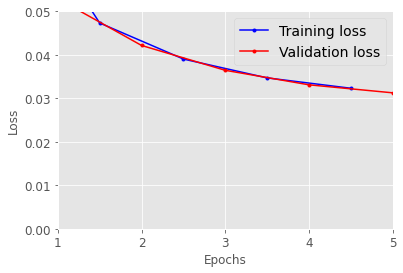

In [60]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [61]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

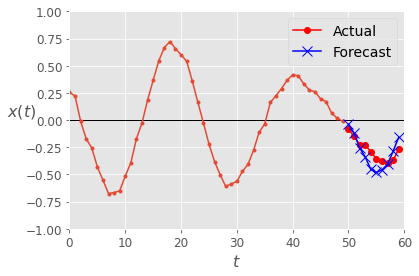

In [62]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [63]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 8s 39ms/step - loss: 0.0766 - last_time_step_mse: 0.0687 - val_loss: 0.0522 - val_last_time_step_mse: 0.0412
Epoch 2/5
219/219 [==============================] - 8s 37ms/step - loss: 0.0476 - last_time_step_mse: 0.0366 - val_loss: 0.0441 - val_last_time_step_mse: 0.0329
Epoch 3/5
219/219 [==============================] - 9s 40ms/step - loss: 0.0424 - last_time_step_mse: 0.0311 - val_loss: 0.0405 - val_last_time_step_mse: 0.0293
Epoch 4/5
219/219 [==============================] - 9s 41ms/step - loss: 0.0390 - last_time_step_mse: 0.0273 - val_loss: 0.0366 - val_last_time_step_mse: 0.0246
Epoch 5/5
219/219 [==============================] - 8s 37ms/step - loss: 0.0341 - last_time_step_mse: 0.0220 - val_loss: 0.0315 - val_last_time_step_mse: 0.0178


In [64]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0315 - last_time_step_mse: 0.0178


[0.03151826187968254, 0.017800748348236084]

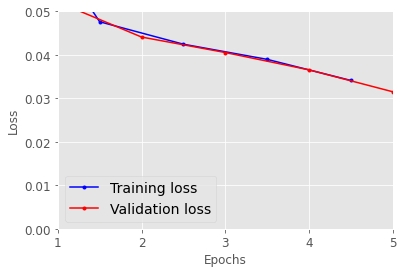

In [65]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [66]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

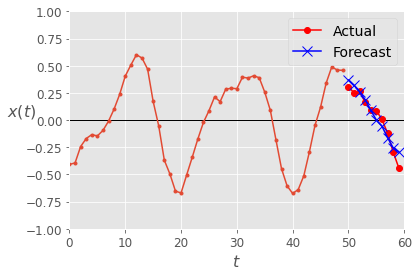

In [67]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [68]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=5,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/5
219/219 [==============================] - 5s 22ms/step - loss: 0.0711 - last_time_step_mse: 0.0639 - val_loss: 0.0448 - val_last_time_step_mse: 0.0372
Epoch 2/5
219/219 [==============================] - 4s 20ms/step - loss: 0.0377 - last_time_step_mse: 0.0308 - val_loss: 0.0337 - val_last_time_step_mse: 0.0253
Epoch 3/5
219/219 [==============================] - 4s 19ms/step - loss: 0.0315 - last_time_step_mse: 0.0234 - val_loss: 0.0291 - val_last_time_step_mse: 0.0197
Epoch 4/5
219/219 [==============================] - 4s 19ms/step - loss: 0.0281 - last_time_step_mse: 0.0185 - val_loss: 0.0262 - val_last_time_step_mse: 0.0158
Epoch 5/5
219/219 [==============================] - 4s 20ms/step - loss: 0.0252 - last_time_step_mse: 0.0145 - val_loss: 0.0239 - val_last_time_step_mse: 0.0131


## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [69]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 2s 10ms/step - loss: 0.0693 - last_time_step_mse: 0.0575 - val_loss: 0.0359 - val_last_time_step_mse: 0.0225
Epoch 2/5
219/219 [==============================] - 2s 8ms/step - loss: 0.0320 - last_time_step_mse: 0.0189 - val_loss: 0.0296 - val_last_time_step_mse: 0.0169
Epoch 3/5
219/219 [==============================] - 2s 7ms/step - loss: 0.0284 - last_time_step_mse: 0.0159 - val_loss: 0.0269 - val_last_time_step_mse: 0.0142
Epoch 4/5
219/219 [==============================] - 2s 7ms/step - loss: 0.0266 - last_time_step_mse: 0.0142 - val_loss: 0.0252 - val_last_time_step_mse: 0.0124
Epoch 5/5
219/219 [==============================] - 2s 7ms/step - loss: 0.0250 - last_time_step_mse: 0.0125 - val_loss: 0.0245 - val_last_time_step_mse: 0.0118


Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [70]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [71]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [72]:
keras.backend.clear_session()

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [73]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 2s 11ms/step - loss: 0.1292 - last_time_step_mse: 0.1224 - val_loss: 0.1228 - val_last_time_step_mse: 0.1185
Epoch 2/2
219/219 [==============================] - 2s 10ms/step - loss: 0.1221 - last_time_step_mse: 0.1152 - val_loss: 0.1218 - val_last_time_step_mse: 0.1177
